[Episode 0] Steps: 100, Total attached: 96, Success: True


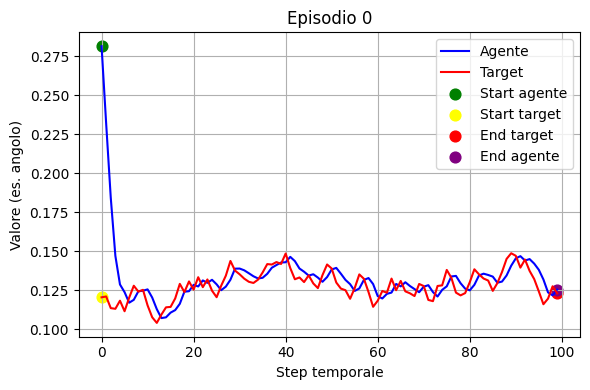

[Episode 1] Steps: 100, Total attached: 12, Success: False


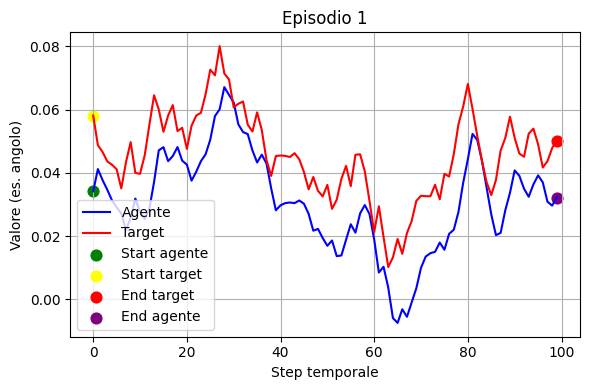

[Episode 2] Steps: 100, Total attached: 0, Success: False


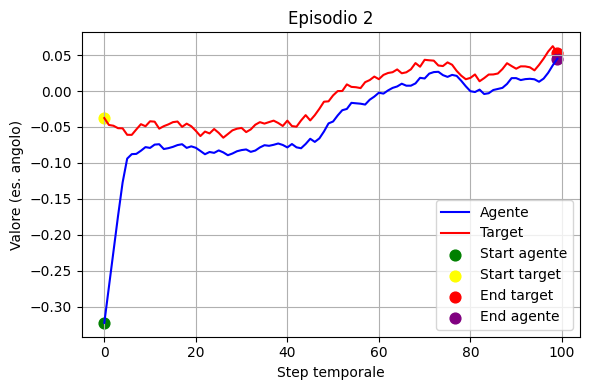

[Episode 3] Steps: 100, Total attached: 1, Success: False


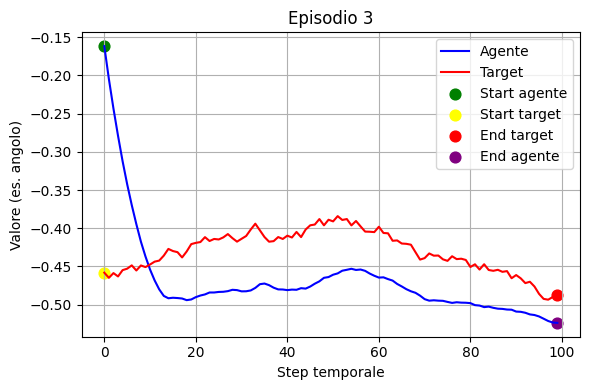

[Episode 4] Steps: 100, Total attached: 3, Success: False


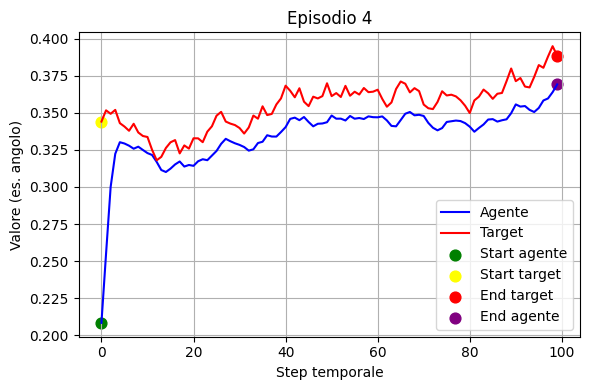

[Episode 5] Steps: 100, Total attached: 43, Success: False


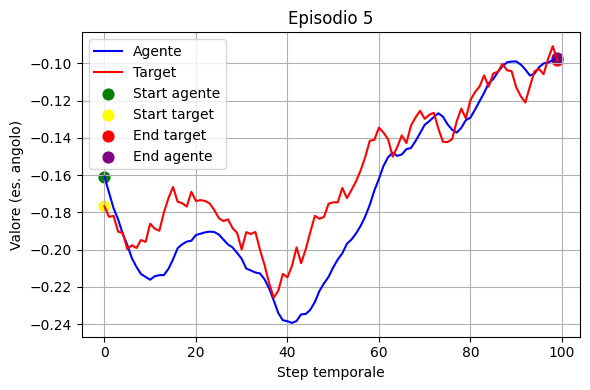

[Episode 6] Steps: 100, Total attached: 32, Success: False


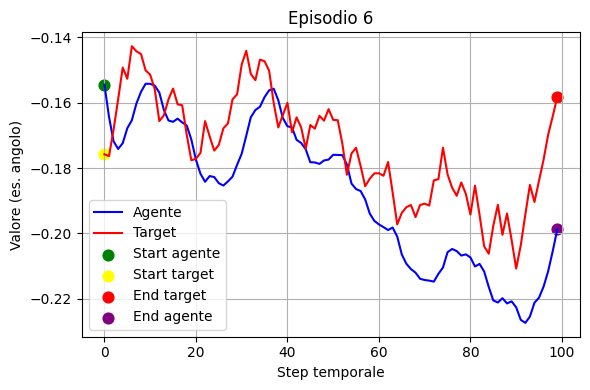

[Episode 7] Steps: 100, Total attached: 2, Success: False


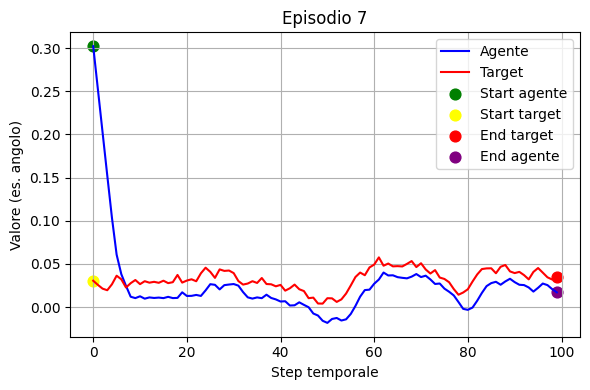

[Episode 8] Steps: 100, Total attached: 52, Success: False


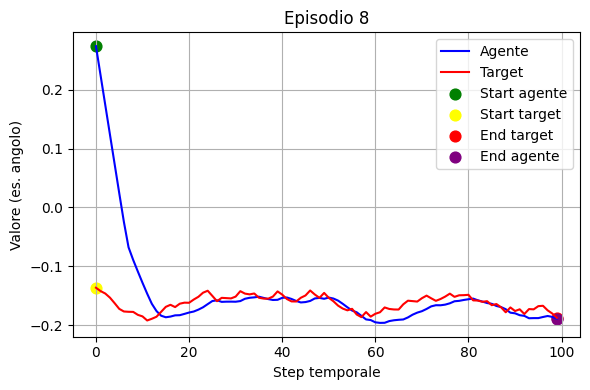

[Episode 9] Steps: 100, Total attached: 2, Success: False


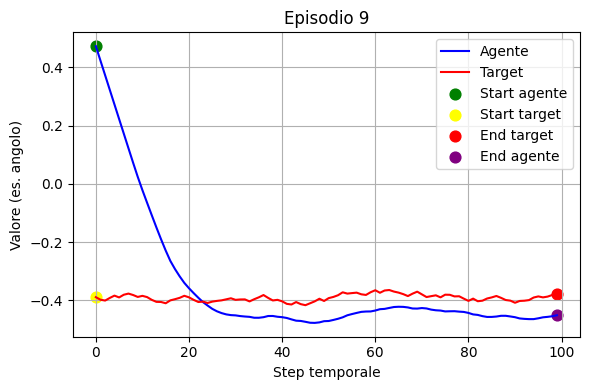


Media step attaccati: 24.30
Successi (attaccato per ≥ 20 step): 1 / 10


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            if torch.abs(real_next_state[0] - real_state[1]) < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = attached_counter > 80
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 20 step): {success_counter} / {num_episodes}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward.zip"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 0, Mean distance: 0.0405, Success: False


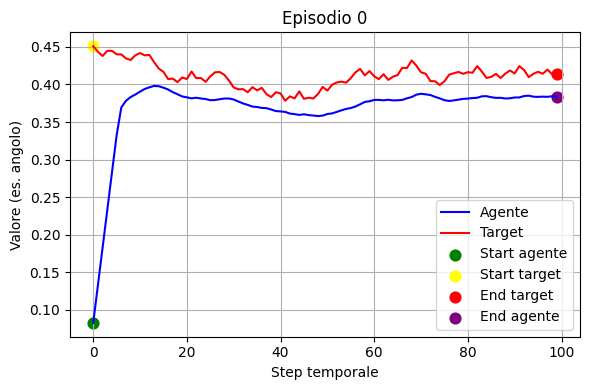

[Episode 1] Steps: 100, Total attached: 39, Mean distance: 0.0341, Success: False


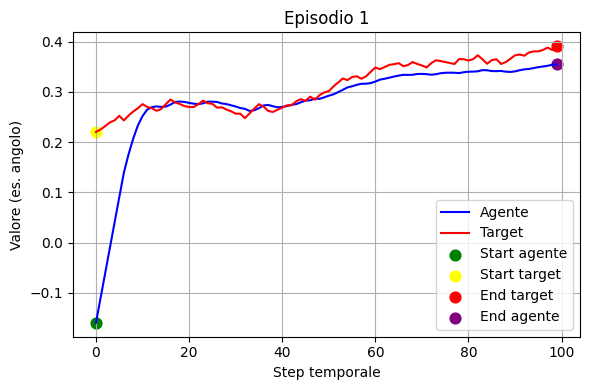

[Episode 2] Steps: 100, Total attached: 11, Mean distance: 0.0294, Success: False


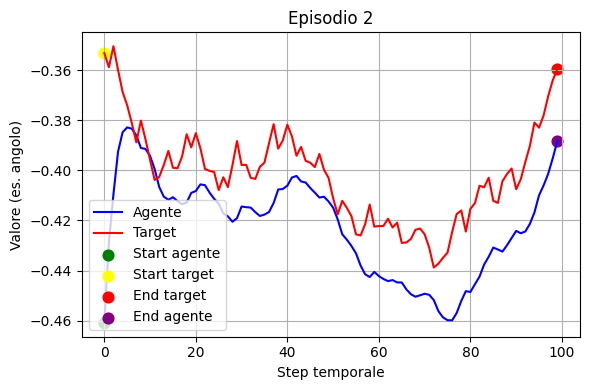

[Episode 3] Steps: 100, Total attached: 16, Mean distance: 0.0415, Success: False


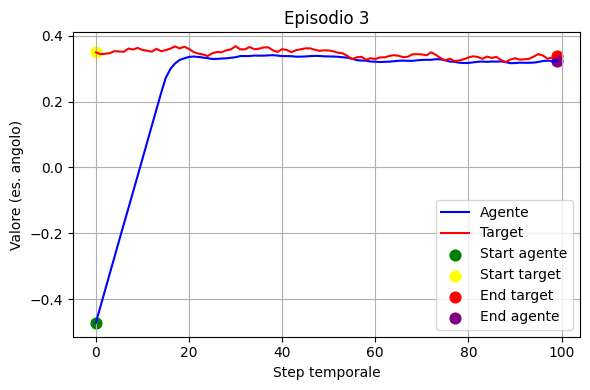

[Episode 4] Steps: 100, Total attached: 72, Mean distance: 0.0451, Success: False


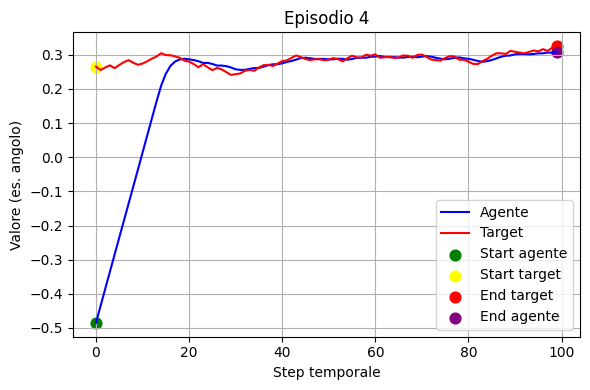

[Episode 5] Steps: 100, Total attached: 67, Mean distance: 0.0391, Success: False


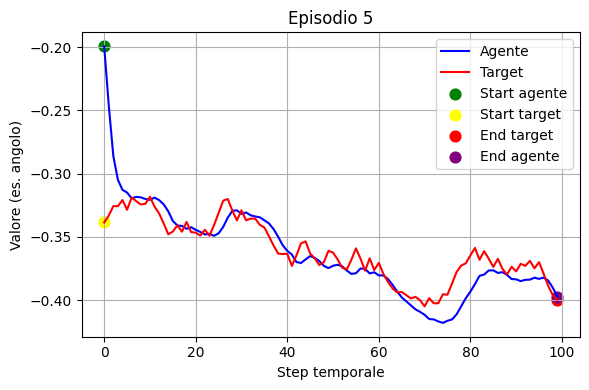

[Episode 6] Steps: 100, Total attached: 0, Mean distance: 0.0439, Success: False


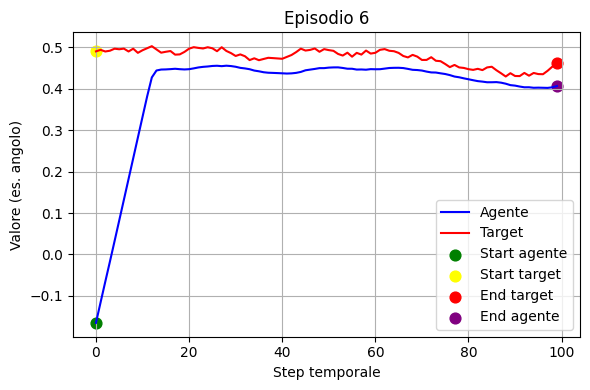

[Episode 7] Steps: 100, Total attached: 78, Mean distance: 0.0414, Success: False


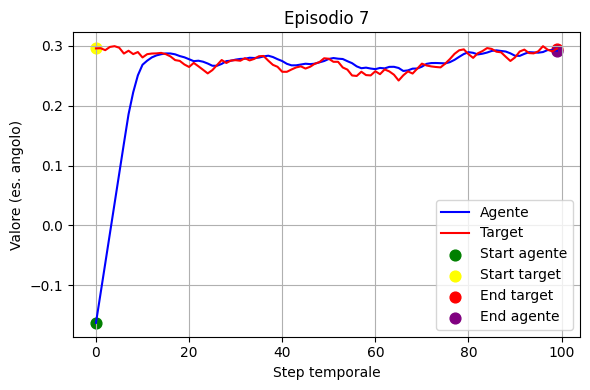

[Episode 8] Steps: 100, Total attached: 49, Mean distance: 0.0384, Success: False


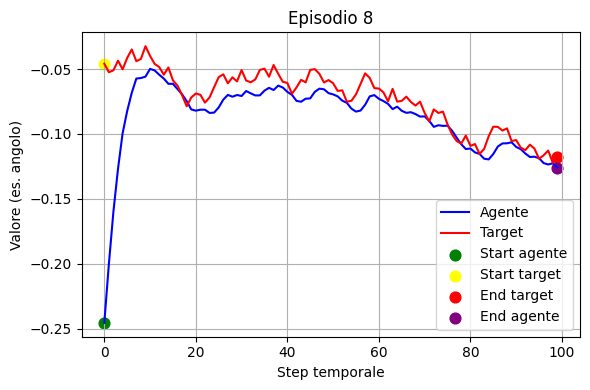

[Episode 9] Steps: 100, Total attached: 41, Mean distance: 0.0356, Success: False


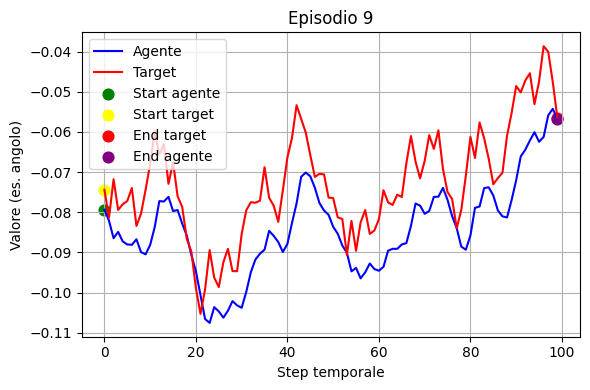


Media step attaccati: 37.30
Successi (attaccato per ≥ 80 step): 0 / 10
Media distanza episodio: 0.0389


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path))
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01"
    reward_path = "IL/DME_SAC/reward_network.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)


[Episode 0] Steps: 100, Total attached: 100, Mean distance: 0.0033, Success: True


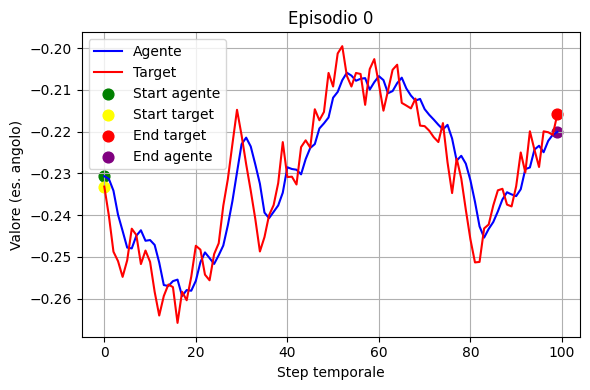

[Episode 1] Steps: 100, Total attached: 53, Mean distance: 0.0097, Success: False


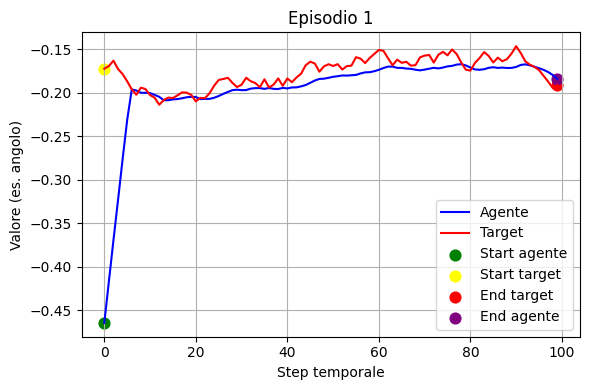

[Episode 2] Steps: 100, Total attached: 25, Mean distance: 0.0160, Success: False


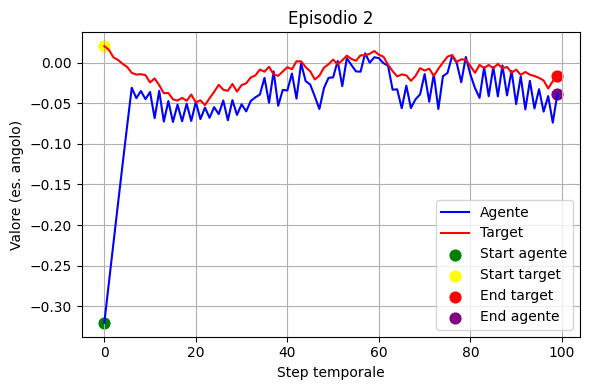

[Episode 3] Steps: 100, Total attached: 96, Mean distance: 0.0136, Success: True


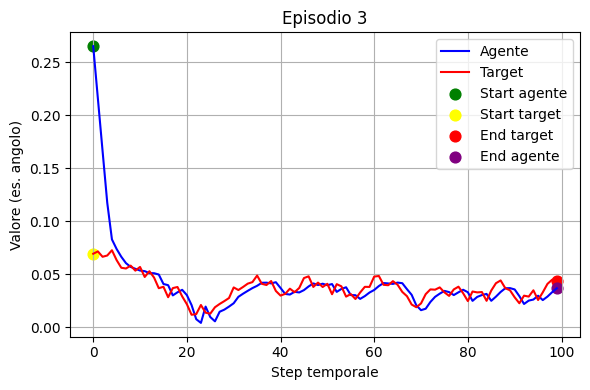

[Episode 4] Steps: 100, Total attached: 96, Mean distance: 0.0121, Success: True


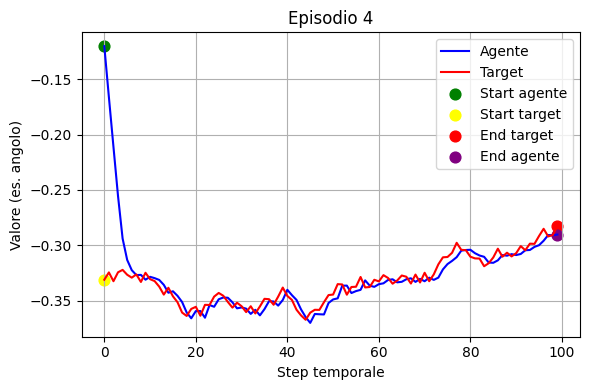

[Episode 5] Steps: 100, Total attached: 50, Mean distance: 0.0139, Success: False


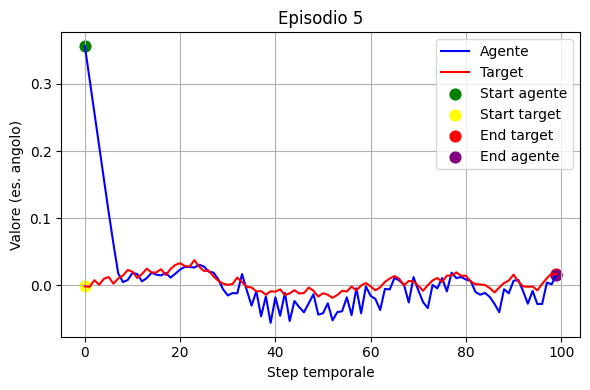

[Episode 6] Steps: 100, Total attached: 92, Mean distance: 0.0132, Success: True


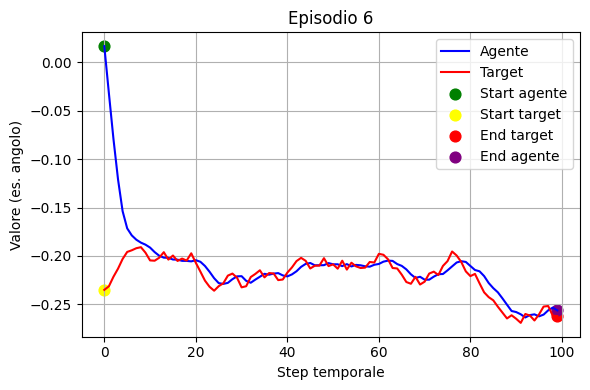

[Episode 7] Steps: 100, Total attached: 84, Mean distance: 0.0192, Success: True


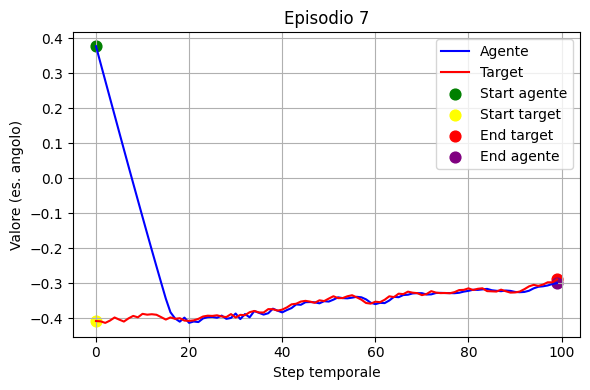

[Episode 8] Steps: 100, Total attached: 50, Mean distance: 0.0183, Success: False


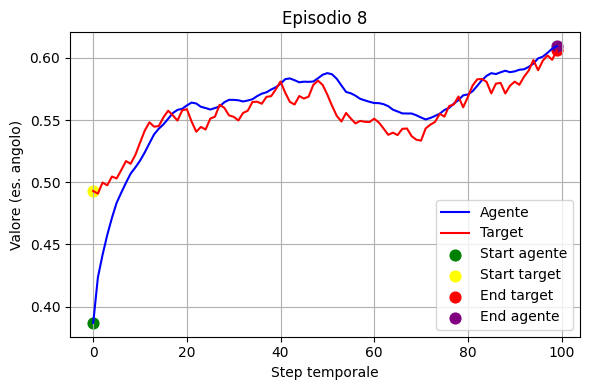

[Episode 9] Steps: 100, Total attached: 97, Mean distance: 0.0169, Success: True


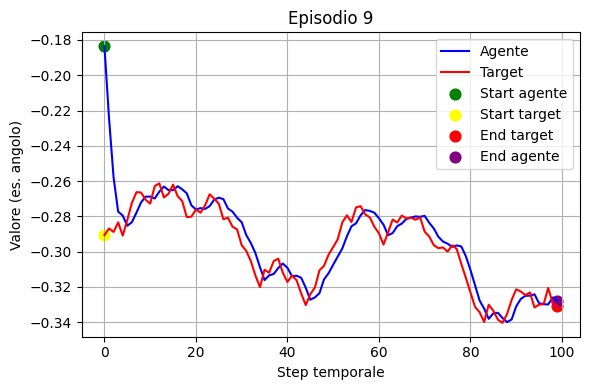


Media step attaccati: 74.30
Successi (attaccato per ≥ 80 step): 6 / 10
Media distanza episodio: 0.0136


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from env_rot import TrackingEnv
from sac_rot import RewardNetwork, IRLEnvWrapper

def load_sac_model(weight_path, reward_path):
    # Crea l’ambiente e la reward net
    env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    device = torch.device("cpu")
    reward_net = RewardNetwork(state_dim, action_dim)
    reward_net.load_state_dict(torch.load(reward_path, map_location=device))
    reward_net.to(device)
    reward_net.eval()

    # Avvolgi l'ambiente con la reward appresa
    wrapped_env = DummyVecEnv([lambda: IRLEnvWrapper(TrackingEnv(), reward_net)])

    # Crea nuovo modello SAC e carica pesi
    model = SAC("MlpPolicy", wrapped_env, verbose=0)
    model.set_parameters(weight_path)
    return model

def test_sac_agent(agent, env=None, num_episodes=10, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0
    episode_distances = []
    mean_distance_episodes = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        real_state = torch.tensor(obs, dtype=torch.float32)
        state = torch.tensor(obs, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].item())
            target_trajectory.append(state[1].item())

            action, _ = agent.predict(obs.reshape(1, -1), deterministic=True)
            next_obs, _, _, truncated, _ = env.step(action[0])

            real_next_state = torch.tensor(next_obs, dtype=torch.float32)
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            dist = torch.abs(real_next_state[0] - real_state[1])
            episode_distances.append(dist.item())

            if dist < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated
            state = next_state
            real_state = real_next_state
            obs = next_obs
            step += 1

        ep_attached_counter.append(total_attached_counter)
        success = total_attached_counter > 80
        if success:
            success_counter += 1

        mean_distance = np.mean(episode_distances)
        mean_distance_episodes.append(mean_distance)

        print(f"[Episode {ep}] Steps: {step}, Total attached: {total_attached_counter}, Mean distance: {mean_distance:.4f}, Success: {success}")

        # Plot
        trajectory = np.array(trajectory)
        target_trajectory = np.array(target_trajectory)
        plt.figure(figsize=(6, 4))
        plt.plot(trajectory, label="Agente", color='blue')
        plt.plot(target_trajectory, label="Target", color='red')
        plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
        plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
        plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
        plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
        plt.title(f"Episodio {ep}")
        plt.xlabel("Step temporale")
        plt.ylabel("Valore (es. angolo)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    env.close()
    mean_distances_ep = np.mean(mean_distance_episodes)
    print(f"\nMedia step attaccati: {np.mean(ep_attached_counter):.2f}")
    print(f"Successi (attaccato per ≥ 80 step): {success_counter} / {num_episodes}")
    print(f"Media distanza episodio: {mean_distances_ep:.4f}")

if __name__ == "__main__":
    weight_path = "IL/SAC_POLICY/sac_with_learned_reward_rot_0.5_0.01_IRL"
    reward_path = "IL/DME_SAC/reward_network_rot_0.5_0.01.pt"
    agent = load_sac_model(weight_path, reward_path)
    test_sac_agent(agent)
